# Mini projet 1: Mathis Petrovich

In [1]:
# imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.patches as patches

# keras imports
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout, Flatten, Reshape, Conv2D, MaxPooling2D
from keras.layers import UpSampling2D, concatenate, BatchNormalization
from keras import optimizers
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False, with_a_non_noisy=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    if with_a_non_noisy:
        return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0)
    else:
        return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False, with_a_non_noisy=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
        
    if with_a_non_noisy:
        return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0)
    else:
        return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False, with_a_non_noisy=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    if with_a_non_noisy:
        return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0)
    else:
        imdata = generate_a_drawing(figsize, U, V, noise)
        return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_a_triangle_image(noise=0.0, free_location=False):
    [im, v] = generate_a_triangle(noise, free_location)
    return im

In [3]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    #print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
        #    print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    #print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
        #    print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()
    
def visualize_prediction_2(x, y_gt, y_pred):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy_gt = y_gt.reshape(3,2)
    tri_gt = patches.Polygon(xy_gt, closed=True, fill = False, edgecolor = 'g', linewidth = 5, alpha = 0.5, label="Ground truth")
    ax.add_patch(tri_gt)
    
    xy_pred = y_pred.reshape(3,2)
    tri_pred = patches.Polygon(xy_pred, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5, label="Prediction")
    ax.add_patch(tri_pred)

    plt.legend()
    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

## Simple Classification

In [4]:
LABELS = ["rectangle", "disk", "triangle"]
NLABELS = len(LABELS)

**Step 1:** Creation of the datasets

I normalized the data [0, 1] instead of [0, 255] because it works better for this part.

In [5]:
def prepare_data(dataset):
    X, Y = dataset
    # Normalize data between 0 and 1
    X /= 255
    # hot vector
    Y = np_utils.to_categorical(Y, NLABELS)
    return X,Y

In [6]:
X_train, Y_train = prepare_data(generate_dataset_classification(300, 20))

In [7]:
X_test, Y_test = prepare_data(generate_dataset_classification(600, 20))

In [8]:
def show_one_exemple(X, Y):
    ind = np.random.randint(X.shape[0])
    plt.imshow(X[ind].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    plt.title(LABELS[np.argmax(Y[ind])])
    plt.show()

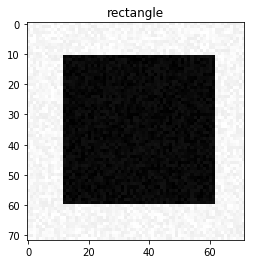

In [9]:
show_one_exemple(X_train, Y_train)

**Step 2:** Creation of the model to classify between classes "rectangle", "disk" and "triangle".

In [10]:
# softmax activation because of multi class label
def create_linear_model(nb_output):
    model = Sequential()
    model.add(Dense(nb_output, activation='linear'))
    return model

**Step 3:** Choose the optimizer and train

In [11]:
def train_linear_model(dataset, opti, nepochs=10, batch_size=32, val_split=0.1, verbose=True):
    X, Y = dataset
    model = create_linear_model(NLABELS)
    model.compile(loss='mean_squared_error', optimizer=opti, metrics=['accuracy'])
    evolution = model.fit(X, Y, epochs=nepochs, batch_size=32, validation_split=val_split, verbose=verbose)
    return model, evolution

In [12]:
def generation_test(out):
    string = "Generation of a " + name + ", prediction: " + out
    return string

def generation_test(model):
    generators = [generate_a_rectangle, generate_a_disk, generate_a_triangle_image]
    for i in range(NLABELS):
        gen = generators[i]
        proba, y = predict_model(model, gen())
        string = "  Generation of a " + LABELS[i] + ", prediction: " + y
        print(string)


In [13]:
# Optimizer
sgd = optimizers.SGD(lr=.3, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.adam()

nepochs = 1000

In [14]:
sgd_model, sgd_evolution = train_linear_model([X_train, Y_train], sgd, nepochs, verbose=False)

In [15]:
adam_model, adam_evolution = train_linear_model([X_train, Y_train], adam, nepochs, verbose=False)

**Step 4:** Visualize the training process

In [16]:
def visualize_training(evolution, modelname, optiname, nepochs=10):
    loss = evolution.history["loss"]
    acc = evolution.history["acc"]
    val_loss = evolution.history["val_loss"]
    val_acc = evolution.history["val_acc"]
    
    X_axe = np.arange(1, nepochs+1)
    fig, axes = plt.subplots(2, 1, figsize=(10,10), sharex="col")
    fig.suptitle("Training the " + modelname + " model with the " + optiname + " optimizer" , size=20)

    # Loss graph
    loss_axe = axes[0]
    loss_axe.plot(X_axe, loss, label="Training")
    loss_axe.plot(X_axe, val_loss, label="Validation")
    loss_axe.set_ylabel('Losses', size=16)
    loss_axe.set_title("Losses", size=18)
    loss_axe.legend()
    
    # Accuracy graph
    acc_axe = axes[1]
    acc_axe.plot(X_axe, acc, label="Training")
    acc_axe.plot(X_axe, val_acc, label="Validation")
    acc_axe.set_xlabel('Iterations', size=16)
    acc_axe.set_ylabel('Accuracy', size=16)
    acc_axe.set_title("Accuracy", size=18)
    acc_axe.legend()
    
    # Show everything
    plt.show()

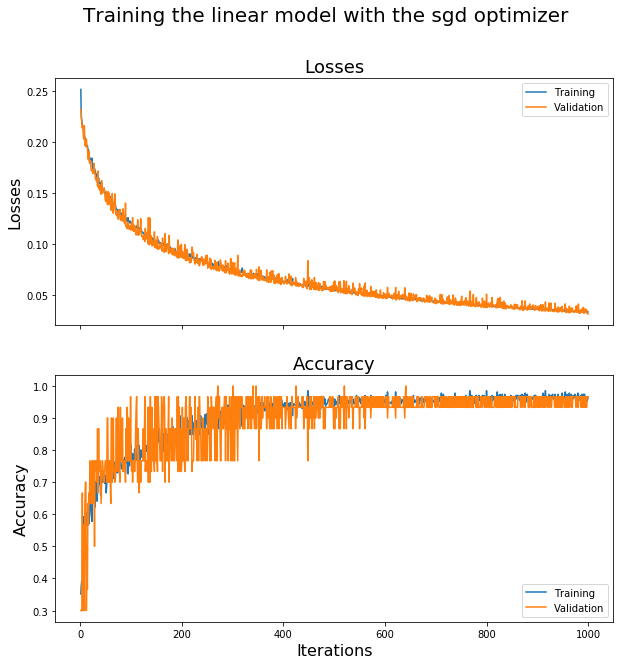

In [17]:
visualize_training(sgd_evolution, "linear", "sgd", nepochs)

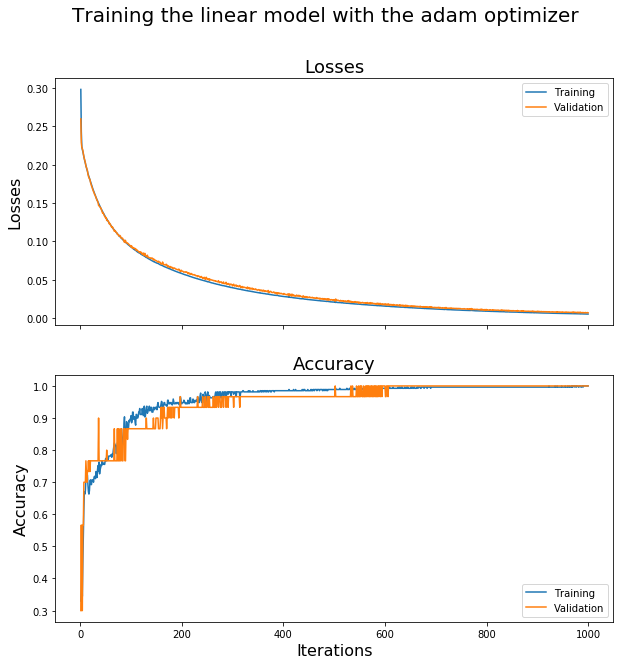

In [18]:
visualize_training(adam_evolution, "linear", "adam", nepochs)

**Step 5:** Do some tests

In [19]:
def predict_model(model, x):
    x = x[None,:]
    proba = model.predict(x)
    y = LABELS[np.argmax(proba)]
    return proba, y
    
def test_model(model, dataset, verbose=False):
    X, Y = dataset
    loss, acc = model.evaluate(X, Y, verbose=verbose)
    return acc, loss

def print_results(opti, acc, loss):
    print(opti + ": accuracy =", round(100*acc), "%, loss =", loss)

In [20]:
print("Random test with sgd optimizer")
generation_test(sgd_model)

Random test with sgd optimizer
  Generation of a rectangle, prediction: disk
  Generation of a disk, prediction: disk
  Generation of a triangle, prediction: triangle


In [21]:
print("Random test with adam optimizer")
generation_test(sgd_model)

Random test with adam optimizer
  Generation of a rectangle, prediction: disk
  Generation of a disk, prediction: disk
  Generation of a triangle, prediction: triangle


Evaluate on the test dataset

In [22]:
sgd_acc, sgd_loss = test_model(sgd_model, [X_test, Y_test])
print_results("sgd", sgd_acc, sgd_loss)

sgd: accuracy = 98.0 %, loss = 0.03819722138345241


In [23]:
adam_acc, adam_loss = test_model(adam_model, [X_test, Y_test])
print_results("adam", adam_acc, adam_loss)

adam: accuracy = 100.0 %, loss = 0.007649400842686494


## Visualization of the Solution

In [24]:
def visualize_model_weights(model, optiname):
    w = model.get_weights()[0].T
    fig, axes = plt.subplots(1, 3, figsize=(30,10), sharey="row")
    fig.suptitle("Visualisation of the weight of the model with the " + optiname + " optimizer", size=30)

    # Show images
    for i in range(NLABELS):
        l_axe = axes[i]
        wi = w[i].reshape(IMAGE_SIZE, IMAGE_SIZE)
        l_axe.imshow(wi, cmap="gray")
        l_axe.set_title(LABELS[i], size=25)
    
    # Show everything
    plt.show()

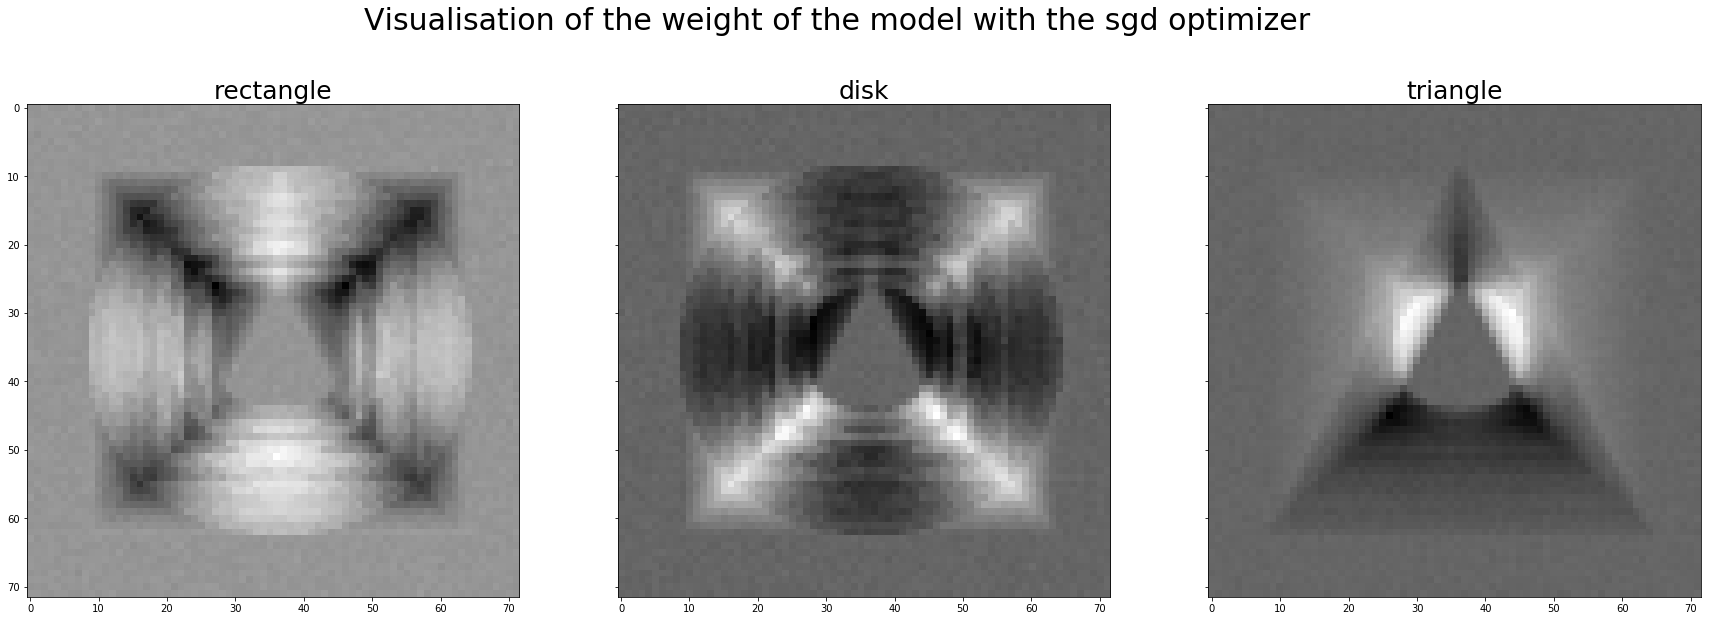

In [25]:
visualize_model_weights(sgd_model, "sgd")

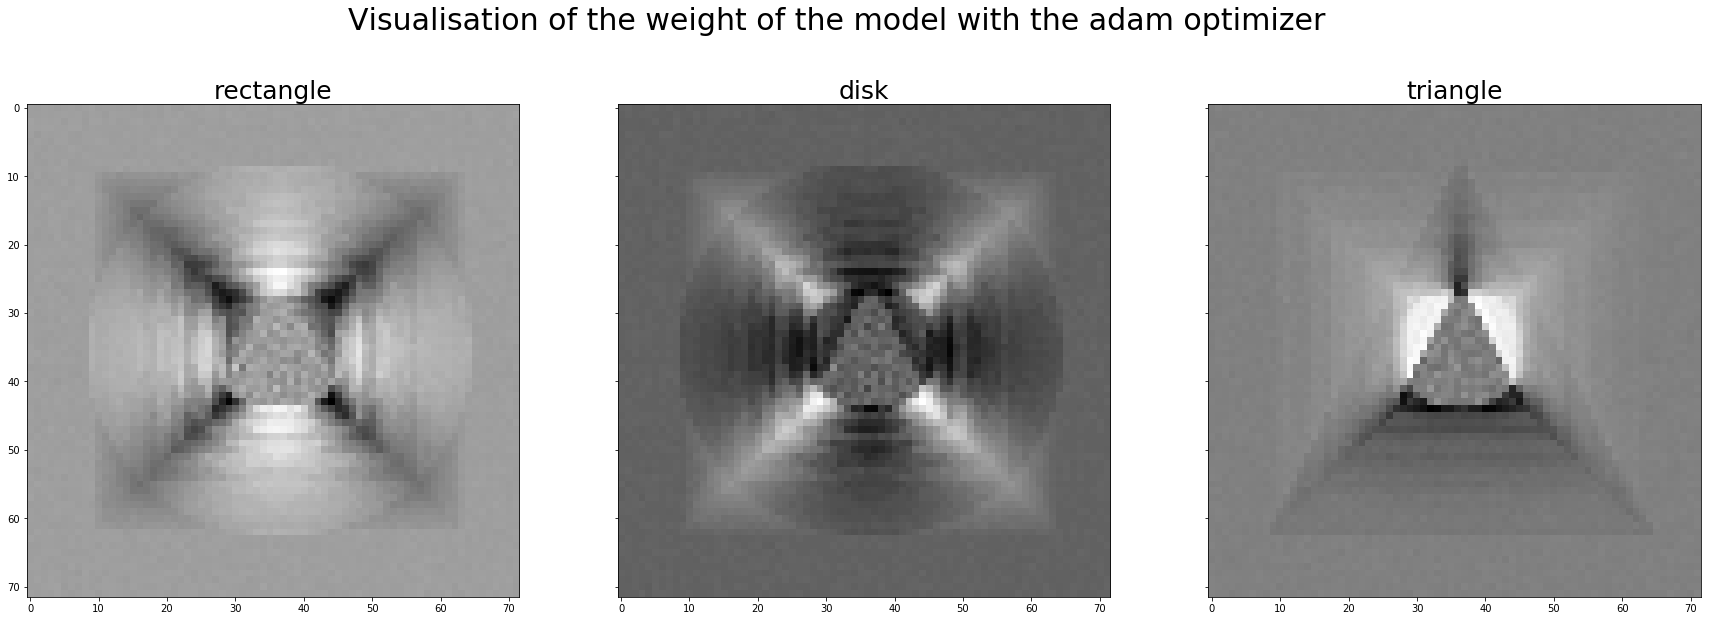

In [26]:
visualize_model_weights(adam_model, "adam")

We can notice that in both models we can see the shapes

## A More Difficult Classification Problem 

**Step 1:** Creation of the datasets (I remove the normalisation here to have better results)

In [27]:
def prepare_data_conv(dataset):
    X, Y = dataset
    # hot vector
    Y = np_utils.to_categorical(Y, NLABELS)
    return X,Y

In [28]:
X_train, Y_train = prepare_data_conv(generate_dataset_classification(1000, 20, True))

In [29]:
X_test, Y_test = prepare_data_conv(generate_dataset_classification(600, 20, True))

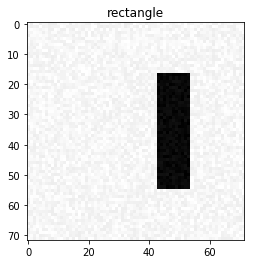

In [30]:
show_one_exemple(X_train, Y_train)

**Step 2:** Creation of the model to classify between classes "rectangle", "disk" and "triangle".

Note that I use here a softmax activation for the last layer

In [31]:
def create_small_conv_model(nb_output):
    model = Sequential()
    model.add(Reshape((IMAGE_SIZE, IMAGE_SIZE, 1), input_shape=(IMAGE_SIZE*IMAGE_SIZE,)))
    model.add(Conv2D(16, (5,5), activation="relu", input_shape=(IMAGE_SIZE, IMAGE_SIZE)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(nb_output, activation='softmax'))
    return model

**Step 3:** Choose the optimizer and train

In [32]:
# Optimizer
adam = optimizers.adam(decay=1e-6)
nepochs = 50

I use here a categorical_crossentropy loss, because it works great

In [33]:
def train_small_conv_model(dataset, opti, nepochs=10, batch_size=32, val_split=0.1, verbose=True):
    X, Y = dataset
    model = create_small_conv_model(NLABELS)
    model.compile(loss='categorical_crossentropy', optimizer=opti, metrics=['accuracy'])
    evolution = model.fit(X, Y, epochs=nepochs, batch_size=32, validation_split=val_split, verbose=verbose)
    return model, evolution

In [34]:
conv_model, conv_evolution = train_small_conv_model([X_train, Y_train], adam, nepochs, verbose=False)

**Step 4:** Visualize the training process

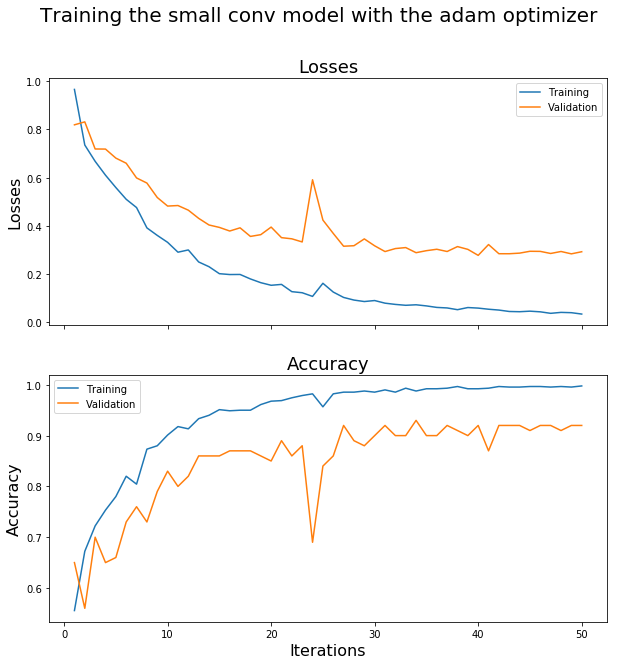

In [35]:
visualize_training(conv_evolution, "small conv", "adam", nepochs)

**Step 5:** Do some tests, note that I use the categorical_crossentropy loss

In [36]:
print("Random test of the small conv model")
generation_test(conv_model)

Random test of the small conv model
  Generation of a rectangle, prediction: rectangle
  Generation of a disk, prediction: triangle
  Generation of a triangle, prediction: disk


Evaluate on the test dataset

In [37]:
conv_acc, conv_loss = test_model(conv_model, [X_test, Y_test])
print_results("conv", conv_acc, conv_loss)

conv: accuracy = 88.0 %, loss = 0.3795220677057902


## A Regression Problem

**Step 1:** Creation of the datasets and normalize data

To normalize data, I tried to sort the label by the x-axis

In [38]:
def prepare_reg_data(dataset):
    X, Y = dataset
    # normalize Y
    normalized_Y = np.zeros_like(Y)
    # for all examples
    for i in range(len(Y)):
        y = Y[i]
        # arrays of x's cordinate
        b = np.sum(y.reshape(3,2) * np.array([1,0]), axis=1)
        cords = np.zeros(6, dtype=int)
        cords[::2] = np.argsort(b)*2
        cords[1::2] = np.argsort(b)*2 + 1
        # sorting of y
        normalized_Y[i] = y[cords]

    return X, normalized_Y

In [39]:
X_reg_train, Y_reg_train =  prepare_reg_data(generate_dataset_regression(1000, 20))

In [40]:
X_reg_test, Y_reg_test =  prepare_reg_data(generate_dataset_regression(500, 20))

**Step 2:** Creation of the model to regress the cordonate of triangles

In [41]:
def create_reg_conv_model():
    model = Sequential()
    model.add(Reshape((IMAGE_SIZE, IMAGE_SIZE, 1), input_shape=(IMAGE_SIZE*IMAGE_SIZE,)))
    
    model.add(Conv2D(32, (5,5), activation="relu", input_shape=(IMAGE_SIZE, IMAGE_SIZE)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(64, (5,5), activation="relu", input_shape=(IMAGE_SIZE, IMAGE_SIZE)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(128, (5,5), activation="relu", input_shape=(IMAGE_SIZE, IMAGE_SIZE)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(256, (5,5), activation="relu", input_shape=(IMAGE_SIZE, IMAGE_SIZE)))
    
    model.add(Flatten())
    model.add(Dropout(0.1))
    model.add(Dense(6, activation='linear'))
    return model

**Step 3:** Choose the optimizer and train

In [42]:
# Optimizer
adam = optimizers.adam(lr=0.0008, decay=1e-5)
nepochs = 30

In [43]:
def train_reg_conv_model(dataset, opti, nepochs=10, batch_size=32, val_split=0.1, verbose=True):
    X, Y = dataset
    model = create_reg_conv_model()
    model.compile(loss='mean_absolute_error', optimizer=opti, metrics=['accuracy'])
    evolution = model.fit(X, Y, epochs=nepochs, batch_size=32, validation_split=val_split, verbose=verbose)
    return model, evolution

In [44]:
reg_model, reg_evolution = train_reg_conv_model([X_reg_train, Y_reg_train], adam, nepochs, verbose=False)

**Step 4:** Visualize the training process

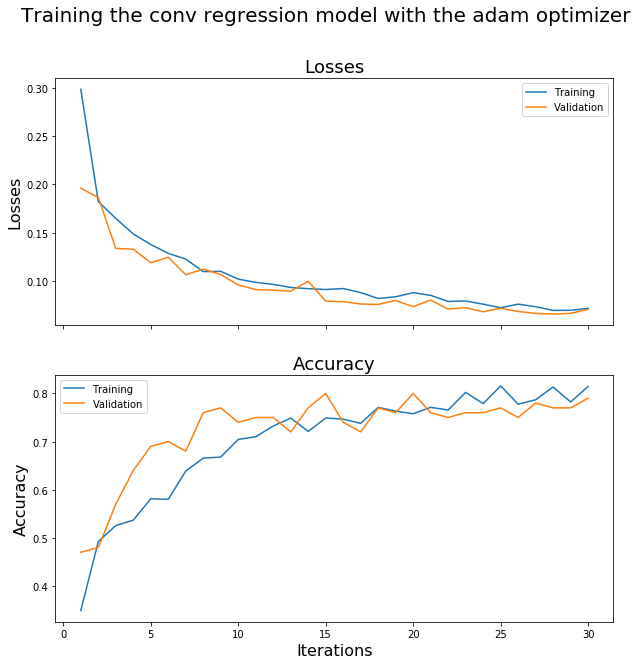

In [45]:
visualize_training(reg_evolution, "conv regression", "adam", nepochs)

**Step 5:** Do some tests

Evaluate on the test dataset

In [46]:
reg_acc, reg_loss = test_model(reg_model, [X_reg_test, Y_reg_test])
print_results("reg conv", reg_acc, reg_loss)

reg conv: accuracy = 81.0 %, loss = 0.06636955425143241


In [47]:
def predict_reg_model(model, x):
    x = x[None,:]
    y = model.predict(x)[0]
    return y

def generation_reg_test(model, x, y, ntest=3):
    for (x,y_gt) in zip(x[:ntest], y[:ntest]):
        y_pred = predict_reg_model(model, x)
        visualize_prediction_2(x, np.array(y_gt), y_pred)

Evalute on random data

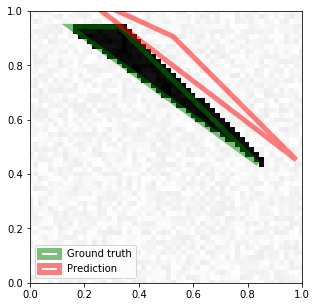

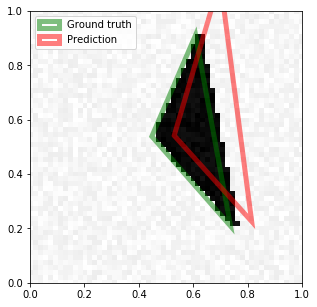

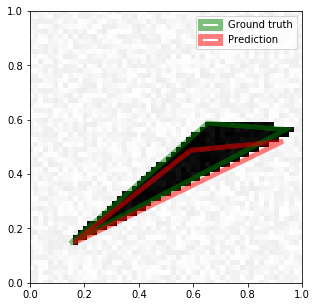

In [48]:
generation_reg_test(reg_model, X_reg_test, Y_reg_test)

## Image Denoising

**Step 1:** Creation of the datasets (noise/without noise)

In [49]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    im_size = IMAGE_SIZE*IMAGE_SIZE
    X = np.zeros([nb_samples,im_size])
    X_no = np.zeros([nb_samples,im_size])
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X[i], X_no[i] = generate_a_rectangle(noise, free_location, with_a_non_noisy=True)
        elif category == 1: 
            X[i], X_no[i] = generate_a_disk(noise, free_location, with_a_non_noisy=True)
        else:
            X[i], X_no[i] = generate_a_triangle(noise, free_location, with_a_non_noisy=True)
    # add noise
    X = (X + noise) / (255 + 2 * noise)
    
    # get binary image
    X_no //= 255
    return [X, X_no.astype(int)]

In [50]:
X, X_no_noise = generate_dataset_classification(300, 20, free_location=True)
X_test, X_no_noise_test = generate_dataset_classification(300, 20, free_location=True)

In [51]:
def show_one_exemple_denoising(X, X_no):
    fig, axes = plt.subplots(1, 2, figsize=(20,10), sharey="row")
    fig.suptitle("Visualisation of noisy version and ground truth", size=30)
    
    ind = np.random.randint(X.shape[0])
    
    # Show noisy version
    n_axe = axes[0]
    n_axe.imshow(X[ind].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap="gray")
    n_axe.set_title("Noisy image", size=25)
    
    # Show denoised version
    no_axe = axes[1]
    no_axe.imshow(X_no[ind].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap="gray")
    no_axe.set_title("Ground truth", size=25)
    
    # Show everything
    plt.show()

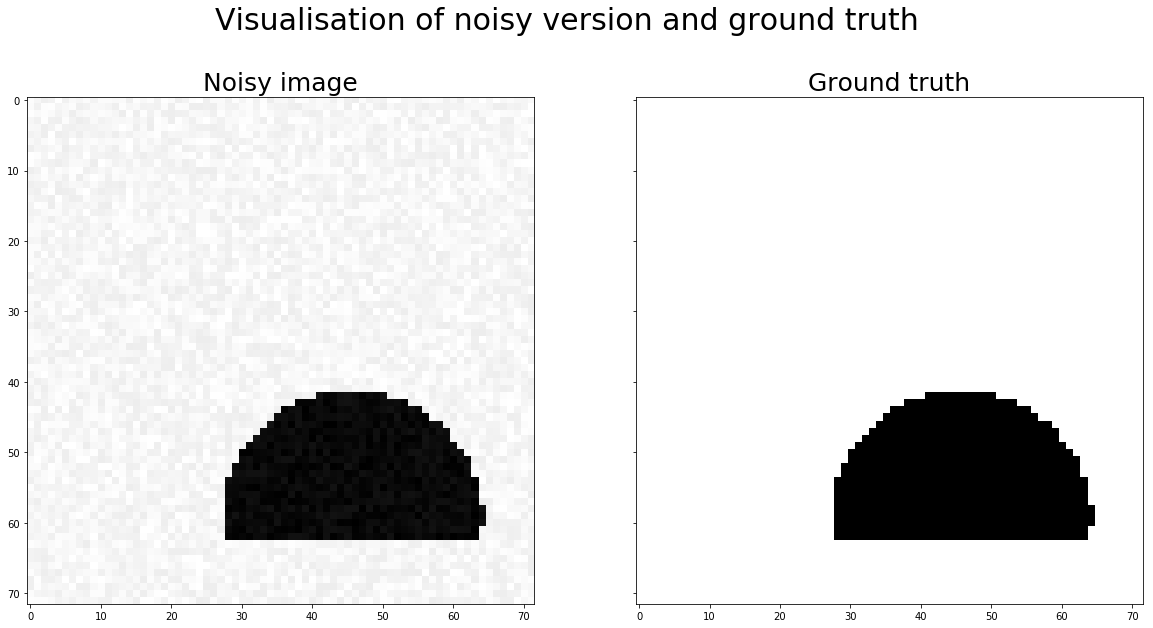

In [52]:
show_one_exemple_denoising(X, X_no_noise)

**Step 2:** Creation of the model (hourglass network) to denoise our pictures 

I created a modified version of SegNet. I use batch normalization before every activation. I don't mix layers like U-net.

In [53]:
def create_denoising_model():
    # process inputs
    inputs = Input((IMAGE_SIZE*IMAGE_SIZE,))
    rinputs = Reshape((IMAGE_SIZE, IMAGE_SIZE, 1), input_shape=(IMAGE_SIZE*IMAGE_SIZE,))(inputs)
    
    # Encoder part
    conv1a = Conv2D(64, 3, padding = 'same')(rinputs)
    bn1a = BatchNormalization()(conv1a)
    act1a = Activation("relu")(bn1a)
    conv1b = Conv2D(64, 3, padding = 'same')(act1a)
    bn1b = BatchNormalization()(conv1b)
    act1b = Activation("relu")(bn1b)
    pool1 = MaxPooling2D()(act1b)
      
    conv2a = Conv2D(128, 3, padding = 'same')(pool1)
    bn2a = BatchNormalization()(conv2a)
    act2a = Activation("relu")(bn2a)
    conv2b = Conv2D(128, 3, padding = 'same')(act2a)
    bn2b = BatchNormalization()(conv2b)
    act2b = Activation("relu")(bn2b)
    pool2 = MaxPooling2D()(act2b)

    conv3a = Conv2D(256, 3, padding = 'same')(pool2)
    bn3a = BatchNormalization()(conv3a)
    act3a = Activation("relu")(bn3a)
    conv3b = Conv2D(256, 3, padding = 'same')(act3a)
    bn3b = BatchNormalization()(conv3b)
    act3b = Activation("relu")(bn3b)
    pool3 = MaxPooling2D()(act3b)
    
    conv4a = Conv2D(512, 3, padding = 'same')(pool3)
    bn4a = BatchNormalization()(conv4a)
    act4a = Activation("relu")(bn4a)
    conv4b = Conv2D(512, 3, padding = 'same')(act4a)
    bn4b = BatchNormalization()(conv4b)
    act4b = Activation("relu")(bn4b)
    
    
    # Decoder part
    up5 = UpSampling2D()(act4b)
    conv5b = Conv2D(256, 2, padding = 'same')(up5)
    bn5b = BatchNormalization()(conv5b)
    act5b = Activation("relu")(bn5b)
    conv5c = Conv2D(256, 3, padding = 'same')(act5b)
    bn5c = BatchNormalization()(conv5c)
    act5c = Activation("relu")(bn5c)
    conv5d = Conv2D(256, 3, padding = 'same')(act5c)
    bn5d = BatchNormalization()(conv5d)
    act5d = Activation("relu")(bn5d)
 
    up6 = UpSampling2D()(act5d)
    conv6b = Conv2D(128, 2, padding = 'same')(up6)
    bn6b = BatchNormalization()(conv6b)
    act6b = Activation("relu")(bn6b)
    conv6c = Conv2D(128, 3, padding = 'same')(act6b)
    bn6c = BatchNormalization()(conv6c)
    act6c = Activation("relu")(bn6c)
    conv6d = Conv2D(128, 3, padding = 'same')(act6c)
    bn6d = BatchNormalization()(conv6d)
    act6d = Activation("relu")(bn6d)
    
    up7 = UpSampling2D()(act6d)
    conv7b = Conv2D(64, 2, padding = 'same')(up7)
    bn7b = BatchNormalization()(conv7b)
    act7b = Activation("relu")(bn7b)
    conv7c = Conv2D(64, 3, padding = 'same')(act7b)
    bn7c = BatchNormalization()(conv7c)
    act7c = Activation("relu")(bn7c)
    conv7d = Conv2D(64, 3, padding = 'same')(act7c)
    bn7d = BatchNormalization()(conv7d)
    act7d = Activation("relu")(bn7d)
    
    conv8 = Conv2D(1, 1, activation='sigmoid')(act7d)
    bn8 = BatchNormalization()(conv8)
    act8 = Activation("relu")(bn8)
    
    # reshape to a vector at the end
    output = Reshape((IMAGE_SIZE*IMAGE_SIZE,), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1))(act8)
    
    # create model
    model = Model(inputs=inputs, outputs=output)
    return model

**Step 3:** Choose the optimizer and train

In [54]:
# Optimizer
adam = optimizers.adam()
adadelta = optimizers.adadelta()
nepochs = 5

In [55]:
def train_denoising_model(dataset, opti, nepochs=10, batch_size=32, val_split=0.1, verbose=True):
    X, Y = dataset
    model = create_denoising_model()
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
    evolution = model.fit(X, Y, epochs=nepochs, batch_size=32, validation_split=val_split, verbose=verbose)
    return model, evolution

Change 0 and 1 because 0 is for background and 1 for the object (the inverse with colors)

In [56]:
denoising_model, denoising_evolution = train_denoising_model([X, 1-X_no_noise], adam, nepochs, verbose=True)

Train on 270 samples, validate on 30 samples
Epoch 1/5
270/270 [==============================] - 130s 481ms/step - loss: 2.4552 - acc: 0.7597 - val_loss: 12.4561 - val_acc: 0.0954
Epoch 2/5
270/270 [==============================] - 125s 462ms/step - loss: 0.8596 - acc: 0.8786 - val_loss: 8.0209 - val_acc: 0.3520
Epoch 3/5
270/270 [==============================] - 125s 463ms/step - loss: 0.4473 - acc: 0.9094 - val_loss: 3.9759 - val_acc: 0.5236
Epoch 4/5
270/270 [==============================] - 125s 464ms/step - loss: 0.3180 - acc: 0.9232 - val_loss: 4.4884 - val_acc: 0.4989
Epoch 5/5
270/270 [==============================] - 125s 463ms/step - loss: 0.2499 - acc: 0.9286 - val_loss: 1.5986 - val_acc: 0.5894


**Step 4:** Visualize the training process

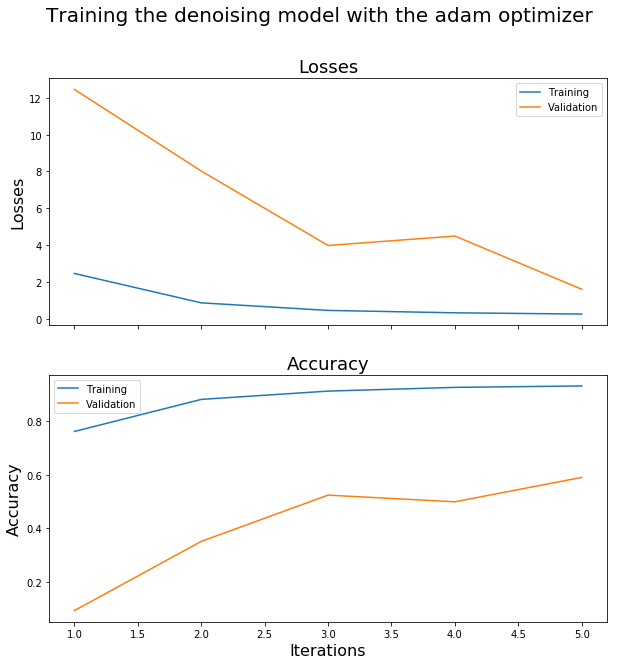

In [57]:
visualize_training(denoising_evolution, "denoising", "adam", nepochs)

**Step 5:** Do some tests

Evaluate on the test dataset

In [58]:
denoising_acc, denoising_loss = test_model(denoising_model, [X_test, 1-X_no_noise_test])
print_results("denoising", denoising_acc, denoising_loss)

denoising: accuracy = 61.0 %, loss = 1.602898546854655


In [59]:
def denoise_image(model, x):
    x = x[None,:]
    x_no = model.predict(x)[0]
    return x_no

In [60]:
def visualize_denoising(X_im, X_no_gt, X_no_pred):
    fig, axes = plt.subplots(1, 3, figsize=(30,10), sharey="row")
    fig.suptitle("Visualisation of noisy version and ground truth", size=30)
    
    # Show noisy version
    n_axe = axes[0]
    n_axe.imshow(X_im.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap="gray")
    n_axe.set_title("Noisy image", size=25)
    
    # Show denoised version
    nop_axe = axes[1]
    nop_axe.imshow(1-X_no_pred.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap="gray")
    nop_axe.set_title("Denoized version", size=25)
    
    # Show ground truth version
    nogt_axe = axes[2]
    nogt_axe.imshow(X_no_gt.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap="gray")
    nogt_axe.set_title("Ground truth", size=25)
    
    # Show everything
    plt.show()

In [61]:
def generation_denoising_test(model, X, X_no, ntest=3):
    inds = [np.random.randint(len(X)) for i in range(ntest)]
    for ind in inds:
        X_im = X[ind]
        X_no_gt = X_no[ind]
        X_no_pred = denoise_image(denoising_model, X_im)
        visualize_denoising(X_im, X_no_gt, X_no_pred)

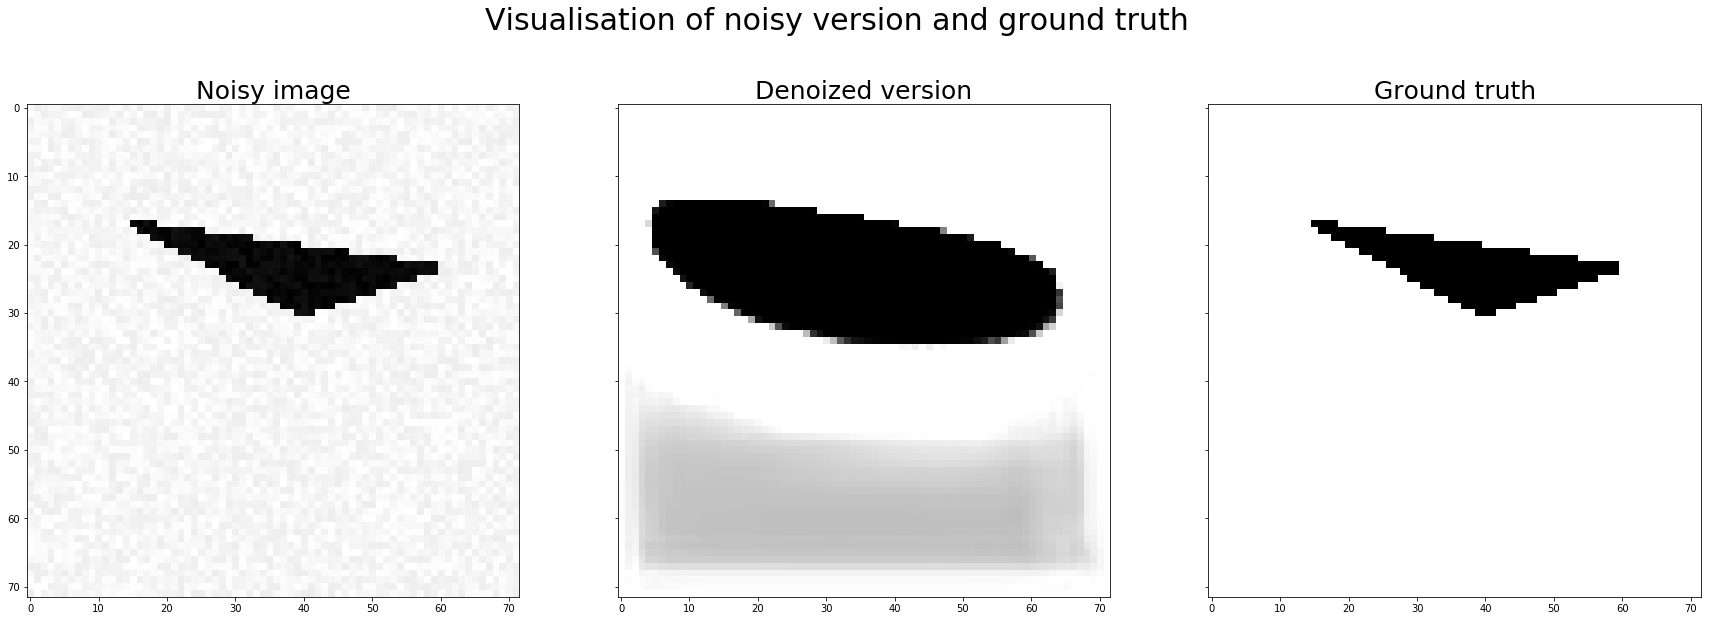

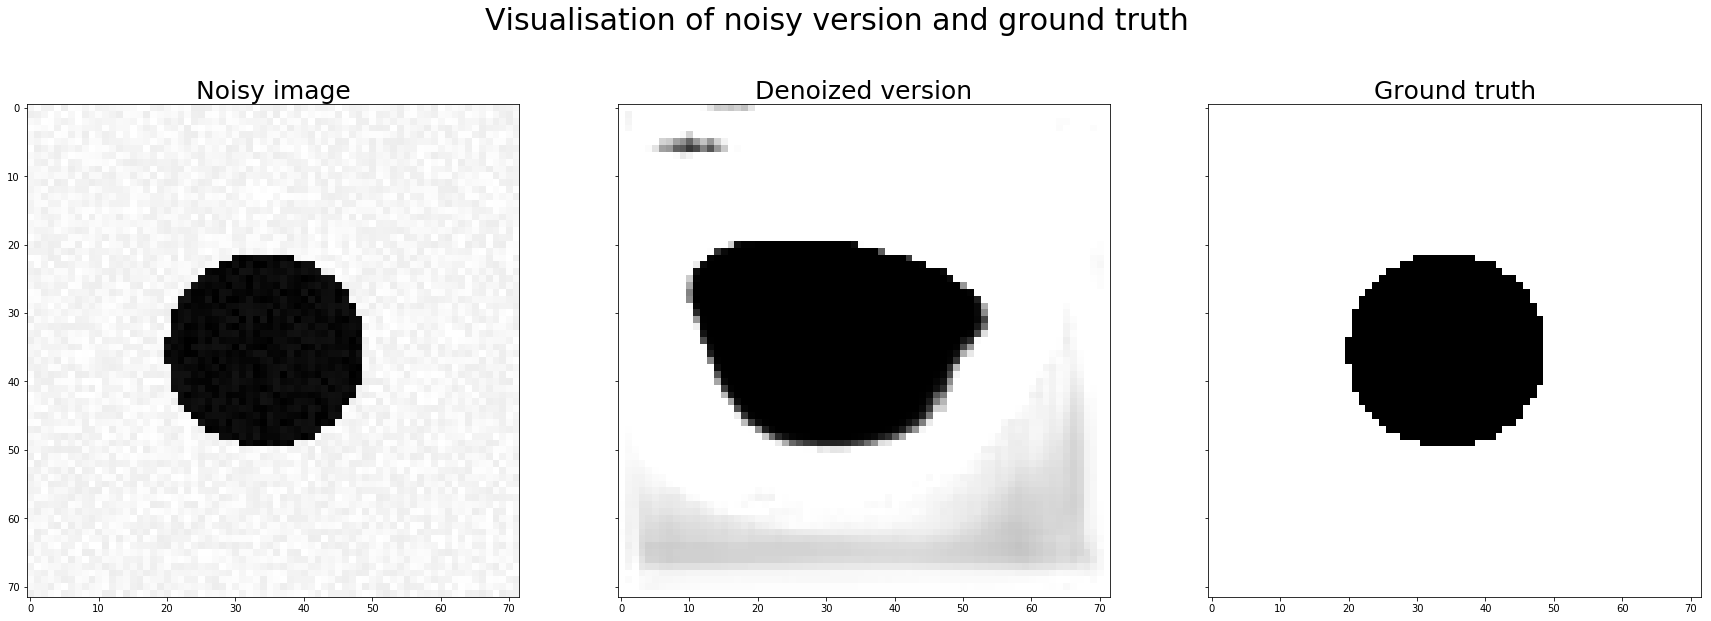

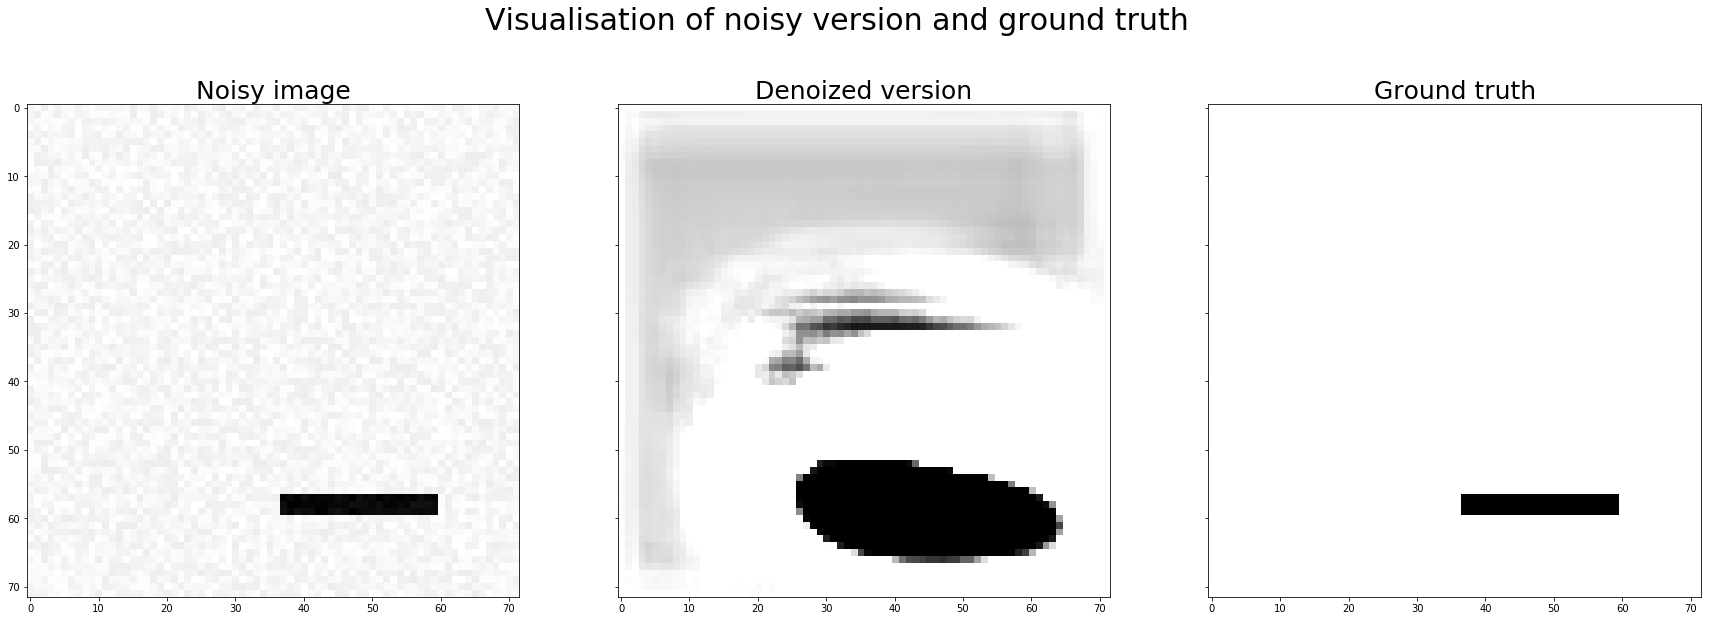

In [64]:
generation_denoising_test(denoising_model, X, X_no_noise)

There are still some artefacts, and the shape are not respected